# 1. Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

import re

from nltk.corpus import stopwords
from wordcloud import WordCloud
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor

from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, SGDRegressor


# 2. Import dataset

In [2]:
train_df = pd.read_csv('./dataset/train.csv') # as the data is huge (~1GB) data is not available in github. To run this, please download the dataset from Kaggle - https://www.kaggle.com/c/jigsaw-unintended-bias-in-toxicity-classification/data
train_df = train_df.drop(['sexual_explicit', 'identity_annotator_count', 'toxicity_annotator_count','created_date','publication_id','parent_id','article_id'], axis=1)
train_df.describe()

,id,target,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,bisexual,...,other_sexual_orientation,physical_disability,psychiatric_or_mental_illness,transgender,white,funny,wow,sad,likes,disagree
count,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,405130.000000,405130.000000,405130.000000,...,405130.000000,405130.000000,405130.000000,405130.000000,405130.00000,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06
mean,3.738434e+06,1.030173e-01,4.582099e-03,1.387721e-02,2.263571e-02,8.115273e-02,9.311271e-03,0.011964,0.003205,0.001884,...,0.001494,0.001356,0.012083,0.006724,0.05695,2.779269e-01,4.420696e-02,1.091173e-01,2.446167e+00,5.843688e-01
std,2.445187e+06,1.970757e-01,2.286128e-02,6.460419e-02,7.873156e-02,1.760657e-01,4.942218e-02,0.087166,0.050193,0.026077,...,0.015374,0.017505,0.089183,0.069027,0.21596,1.055313e+00,2.449359e-01,4.555363e-01,4.727924e+00,1.866589e+00
min,5.984800e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,7.969752e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,5.223774e+06,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00
75%,5.769854e+06,1.666667e-01,0.000000e+00,0.000000e+00,0.000000e+00,9.090909e-02,0.000000e+00,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000e+00,0.000000e+00,0.000000e+00,3.000000e+00,0.000000e+00
max,6.334010e+06,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000,1.000000,1.000000,...,0.750000,1.000000,1.000000,1.000000,1.00000,1.020000e+02,2.100000e+01,3.100000e+01,3.000000e+02,1.870000e+02


In [3]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1804874 entries, 0 to 1804873
Data columns (total 38 columns):
 #   Column                               Dtype  
---  ------                               -----  
 0   id                                   int64  
 1   target                               float64
 2   comment_text                         object 
 3   severe_toxicity                      float64
 4   obscene                              float64
 5   identity_attack                      float64
 6   insult                               float64
 7   threat                               float64
 8   asian                                float64
 9   atheist                              float64
 10  bisexual                             float64
 11  black                                float64
 12  buddhist                             float64
 13  christian                            float64
 14  female                               float64
 15  heterosexual                    

In [4]:
test_df = pd.read_csv("https://drive.google.com/uc?export=download&id=1RcUx5dpbKuDxcXPrq3UVWuLSPOgs_Sjy")
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97320 entries, 0 to 97319
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            97320 non-null  int64 
 1   comment_text  97320 non-null  object
dtypes: int64(1), object(1)
memory usage: 1.5+ MB


In [5]:
test_df.head(5)

,id,comment_text
0,7097320,[ Integrity means that you pay your debts.]\n\...
1,7097321,This is malfeasance by the Administrator and t...
2,7097322,@Rmiller101 - Spoken like a true elitist. But ...
3,7097323,"Paul: Thank you for your kind words. I do, in..."
4,7097324,Sorry you missed high school. Eisenhower sent ...


In [6]:
train_df.head(5)

,id,target,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,...,physical_disability,psychiatric_or_mental_illness,transgender,white,rating,funny,wow,sad,likes,disagree
0,59848,0.000000,"This is so cool. It's like, 'would you want yo...",0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,rejected,0,0,0,0,0
1,59849,0.000000,Thank you!! This would make my life a lot less...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,rejected,0,0,0,0,0
2,59852,0.000000,This is such an urgent design problem; kudos t...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,rejected,0,0,0,0,0
3,59855,0.000000,Is this something I'll be able to install on m...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,rejected,0,0,0,0,0
4,59856,0.893617,haha you guys are a bunch of losers.,0.021277,0.0,0.021277,0.87234,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,rejected,0,0,0,1,0


# 3. Exploratory Data Analysis

### 1. Target Feature

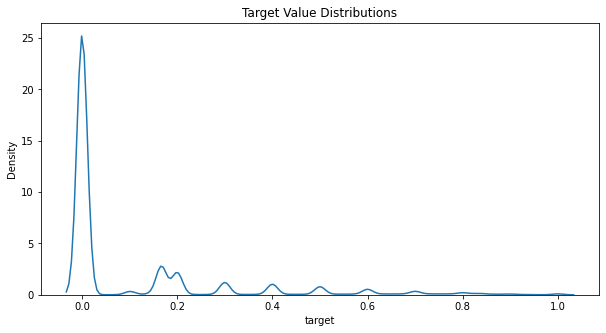

In [7]:
plt.figure(figsize=(10,5))
plt.title('Target Value Distributions')
sns.distplot(train_df['target'], hist=False, bins = 240, label = 'target')
plt.show();


### Most of the comments are non toxic

### 2. Additional toxicity, Gender, Race, Sexual orientation Features

In [8]:
def features_distribution_plot(features, title, data, ax):
    ax.set_title(title, fontsize=10)
    
    for feature in features:
        sns.distplot(data[feature],ax= ax, hist=False, bins=240, label=feature)
        
    ax.set(xlabel='title', ylabel='count')
    ax.legend(loc='upper right')


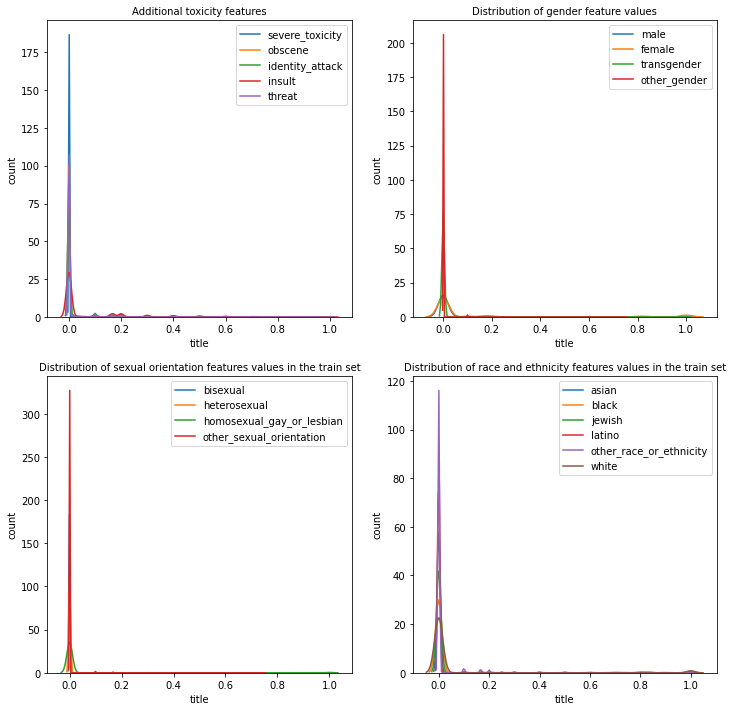

In [9]:
fig, ax = plt.subplots(2,2, figsize=(12,12))

# Plot addictional toxicity features' distribution
toxicity_features = ['severe_toxicity', 'obscene', 'identity_attack', 'insult', 'threat']
features_distribution_plot(toxicity_features, "Additional toxicity features", train_df, ax[0,0])

#Distribution of gender feature values
train_nan_removed = train_df.dropna(axis = 0, how = 'any')
gender_features = ['male', 'female', 'transgender', 'other_gender']
features_distribution_plot(gender_features, "Distribution of gender feature values", train_nan_removed, ax[0,1])

# Distribution of sexual orientation features values
sexual_orientation_features = ['bisexual', 'heterosexual', 'homosexual_gay_or_lesbian', 'other_sexual_orientation']
features_distribution_plot(sexual_orientation_features, "Distribution of sexual orientation features values in the train set", train_nan_removed, ax[1,0])

# Distribution of race and ethnicity features
race_features = ['asian', 'black', 'jewish', 'latino', 'other_race_or_ethnicity', 'white']
features_distribution_plot(race_features, "Distribution of race and ethnicity features values in the train set", train_nan_removed, ax[1,1])


### 3. Toxicity in racist, Sexist and Gender comments

In [15]:
def get_comment_nature(comment):
    most_app_nature = max(comment['severe_toxicity'], comment['obscene'], comment['identity_attack'], comment['insult'], comment['threat'])
    
    if most_app_nature == comment['severe_toxicity']:
        return 'severe_toxicity'
    elif most_app_nature == comment['obscene']:
        return 'obscene'
    elif most_app_nature == comment['identity_attack']:
        return 'identity_attack'
    elif most_app_nature == 'insult':
        return 'insult'
    else: 
        return 'threat'

In [16]:
def plot_perc_toxic_comments(x, axs, title):
    total = float(len(x))

    cntplot = sns.countplot(x,ax = axs)
    cntplot.set_title(title, fontsize = 15)

    # Get the height and calculate percentage then display it the plot itself.
    for p in axs.patches:
        height = p.get_height()
        axs.text(p.get_x() + p.get_width()/2.0, height + 3, '{:1.2f}%'.format(100*height/total), ha='center')


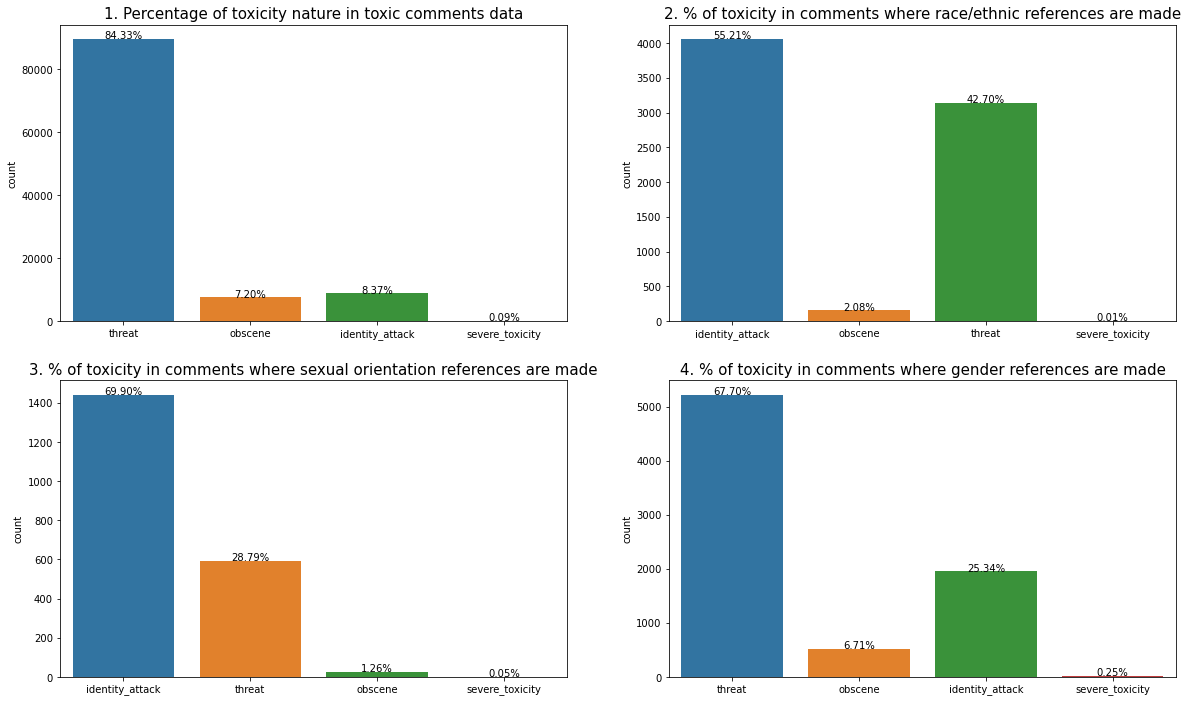

In [17]:
fig, ax = plt.subplots(2,2, figsize=(20,12))

# Percentage of toxicity nature in toxic comments data
x = train_df[train_df['target']>0.5].apply(get_comment_nature, axis=1) 
plot_perc_toxic_comments(x, ax[0,0], '1. Percentage of toxicity nature in toxic comments data')

# Percentage of type of toxicity in comments where race/ethnic references are made
condition_race = (train_df['asian'] > 0.5) | (train_df['black'] > 0.5) | (train_df['jewish'] > 0.5) | (train_df['latino'] > 0.5) | (train_df['white'] > 0.5)
race_trian = train_df[condition_race]
race_trian = race_trian[race_trian['target'] > 0.5] 

racist_comments = race_trian.apply(get_comment_nature, axis=1)
plot_perc_toxic_comments(racist_comments, ax[0,1], '2. % of toxicity in comments where race/ethnic references are made')

# Percentage of type of toxicity in comments where sexual orientation references are made'
sexual_orientation_condition = (train_df['bisexual'] > 0.5) | (train_df['heterosexual'] > 0.5) | (train_df['homosexual_gay_or_lesbian'] > 0.5) | (train_df['other_sexual_orientation'] > 0.5) 
sexual_orient_train = train_df[sexual_orientation_condition]
sexual_orient_train = sexual_orient_train[sexual_orient_train['target'] > 0.5]

sexist_comments = sexual_orient_train.apply(get_comment_nature, axis=1) 
plot_perc_toxic_comments(sexist_comments, ax[1,0], '3. % of toxicity in comments where sexual orientation references are made')

# Percentage of type of toxicity in comments where gender references are made
gender_conditiom = (train_df['male'] > 0.5) | (train_df['female'] > 0.5) | (train_df['transgender'] > 0.5) | (train_df['other_gender'] > 0.5) 
gender_train = train_df[gender_conditiom]
gender_train = gender_train[gender_train['target'] > 0.5] 

gender_comments = gender_train.apply(get_comment_nature, axis=1)
plot_perc_toxic_comments(gender_comments, ax[1,1], '4. % of toxicity in comments where gender references are made')


### Derived conclusions:

##### 1. Percentage of toxicity in toxic comments data - most of the toxic comments are insults

##### 2. % of type of toxicity where race/ethnic references are made - most of the race/ethnic comments are identity_attacks and insults

##### 3. % of type of toxicity in comments where sexual orientation references are made - most of them are identity_attacks and insults

##### 4. % of type of toxicity in comments where gender references are made - most are insults and identity attacks

### 4. Users Feedback Featuers

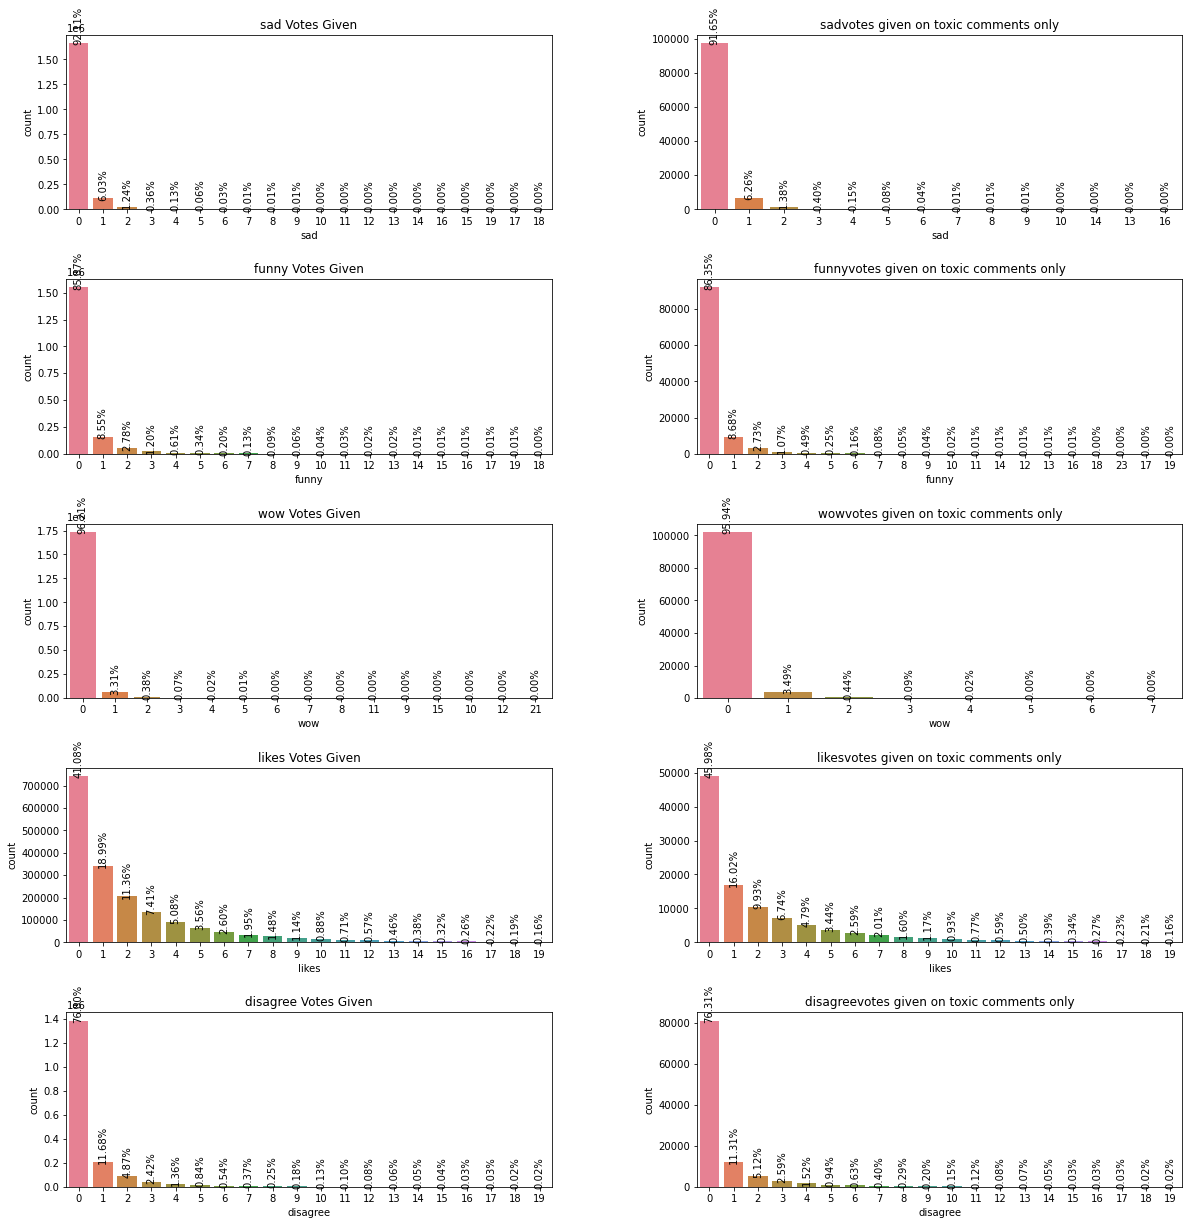

In [18]:
def plot_count(feature, title, data, axs, size = 1):
    total = float(len(data))
    
    cntplt = sns.countplot(data[feature], ax = axs, order = data[feature].value_counts().index[:20], palette = 'husl')
    cntplt.set_title(title)
    
    for p in axs.patches:
        axs.text(p.get_x() + p.get_width()/2., p.get_height() + 3, '{:1.2f}%'.format(100 * p.get_height()/total), ha="center", rotation="vertical")    
    
    plt.subplots_adjust(bottom=0.1,top=0.9, wspace=0.3, hspace=0.4)
    
f, ax = plt.subplots(5,2, figsize=(20,20))
for i, l in enumerate(['sad', 'funny', 'wow', 'likes','disagree']):
    plot_count(l, l + ' votes given', train_df, ax[i,0], 3)
    plot_count(l, l + ' votes given on toxic comments only', train_df[train_df['target'] > 0.5], ax[i,1], 3)


### As you can see in the above bar charts considerable amount of toxic comments are given likes and disagree votes than funny/wow/sad votes.

### 5. Comments Features

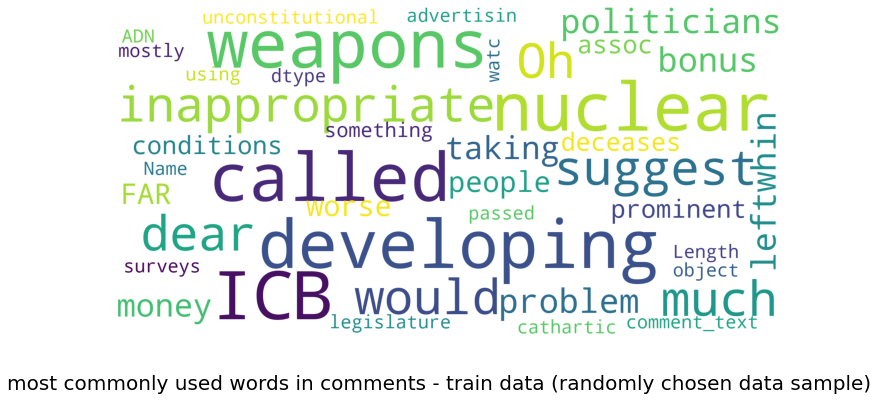

In [21]:
stopWords = stopwords.words('english')

wordcloud = WordCloud(background_color = 'white', stopwords = set(stopWords), max_words = 60, max_font_size = 40, scale = 5).generate(str(train_df['comment_text'].sample(20000)))

fig = plt.figure(1, figsize=(12,12))
plt.axis('off')
fig.suptitle('most commonly used words in comments - train data (randomly chosen data sample)', fontsize = 20)
fig.subplots_adjust(top=2.3)
    
plt.imshow(wordcloud)
plt.show()
    

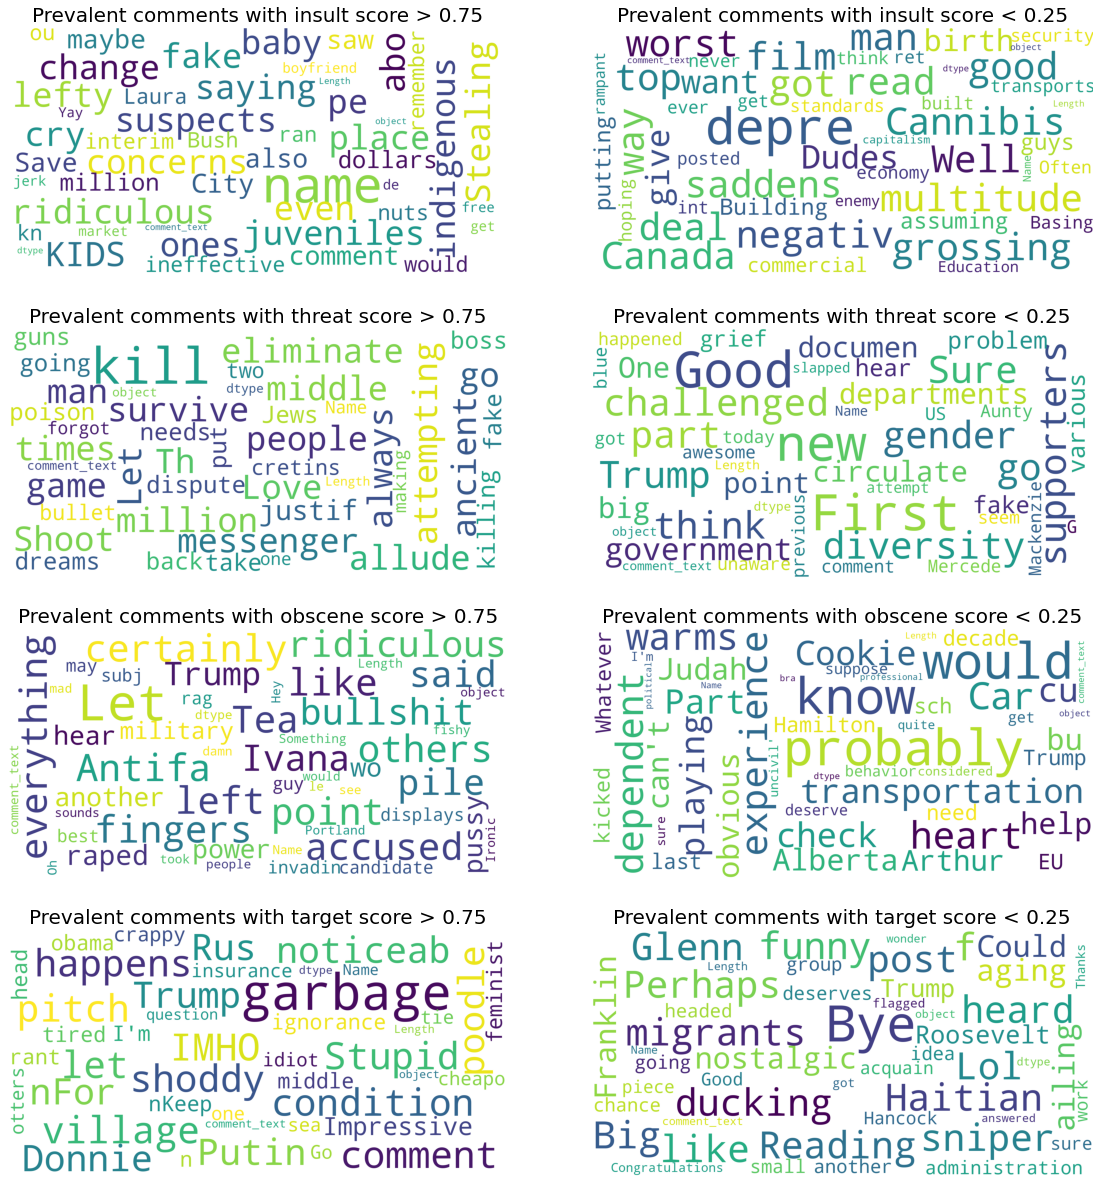

In [22]:
# define a function to create a wordcloud
def word_cloud(data, title, ax, fig):
    wordcloud = WordCloud(background_color = 'white', stopwords = set(stopWords), max_words = 60, max_font_size = 40, scale = 5).generate(str(data))
    ax.axis('off')
    ax.set_title(title, fontsize = 20)
    fig.subplots_adjust(bottom=0.1,top=0.9, wspace=0.1, hspace=0.2)
    ax.imshow(wordcloud)

fig, ax = plt.subplots(4,2, figsize=(20,20))

# show the words in different toxicity categories
for i,l in enumerate(['insult', 'threat', 'obscene', 'target']):
    word_cloud(train_df.loc[train_df[l] > 0.75]['comment_text'].sample(200), 'Prevalent comments with ' + l + ' score > 0.75', ax[i,0], fig)
    word_cloud(train_df.loc[train_df[l] < 0.25]['comment_text'].sample(200), 'Prevalent comments with ' + l + ' score < 0.25', ax[i,1], fig)


# 4. Data Preprocessing and train-test split

In [23]:
def text_process(comments):
    ps = PorterStemmer()
    corpus = []
    for comment in comments.split():
        comment = comment.lower()
        if comment.strip() not in stopWords:
            comment  = re.sub('[^a-zA-Z]', '', ps.stem(comment.strip()))
                    
        corpus.append(comment)
        
    return ' '.join(corpus)
    
    
train_df['preprocessed_text'] = train_df['comment_text'].apply(text_process)

In [24]:
X_train, X_test, y_train, y_test = train_test_split(train_df['preprocessed_text'], train_df['target'])

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1353655,)
(451219,)
(1353655,)
(451219,)


In [25]:
test_df['preprocessed_text'] = test_df['comment_text'].apply(text_process)

# 5. Bag of Words Model

In [26]:
cVector = CountVectorizer(max_features = 30000)
cv_train = cVector.fit_transform(X_train)
cv_test = cVector.fit_transform(X_test)


In [27]:
y_train

1183150    0.000000
1382724    0.300000
175630     0.000000
852920     0.166667
102430     0.000000
             ...   
1085824    0.000000
436114     0.300000
478324     0.200000
451498     0.416667
1021767    0.000000
Name: target, Length: 1353655, dtype: float64

In [28]:
cv_train.shape

(1353655, 30000)

# TF-IDF Model

In [29]:
tfidf_vec = TfidfVectorizer(ngram_range=(1,2), max_features=2000)
tfidf_train = tfidf_vec.fit_transform(X_train)
tfidf_test = tfidf_vec.transform(X_test)

In [30]:
# Performing hyperparameter tuning:
alpha_values = [0.001, 0.01, 0.1, 1, 10]
penalty_values = ['l1', 'l2']

for a in alpha_values:
    for p in penalty_values:
        print("Alpha parameter : " + str(a) + " penalty : " + str(p))
        
        model = SGDRegressor(alpha=a, penalty=p) 
        model.fit(tfidf_train, y_train) 
        
        y_train_predict = model.predict(tfidf_train)
        error = mean_squared_error(y_train, y_train_predict) 
        print("Training  Error:" + str(error))
        
        y_predict = model.predict(tfidf_test) 
        error = mean_squared_error(y_test, y_predict)
        print("Testing error: " + str(error)+"\n")
        

Alpha parameter : 0.001 penalty : l1
Training  Error:0.03799142290735588
Testing error: 0.038199995485895734

Alpha parameter : 0.001 penalty : l2
Training  Error:0.031511528314188485
Testing error: 0.03167764317247837

Alpha parameter : 0.01 penalty : l1
Training  Error:0.03878304568155127
Testing error: 0.03900662995773428

Alpha parameter : 0.01 penalty : l2
Training  Error:0.03673979310228298
Testing error: 0.036944192185194555

Alpha parameter : 0.1 penalty : l1
Training  Error:0.038783021652744706
Testing error: 0.039006375299337176

Alpha parameter : 0.1 penalty : l2
Training  Error:0.03851670650221025
Testing error: 0.038737857912745796

Alpha parameter : 1 penalty : l1
Training  Error:0.03878302505373234
Testing error: 0.0390062971986115

Alpha parameter : 1 penalty : l2
Training  Error:0.038756407282210956
Testing error: 0.0389793338800596

Alpha parameter : 10 penalty : l1
Training  Error:0.03878302465619528
Testing error: 0.03900646243132695

Alpha parameter : 10 penalty : 

#### Based on the Error values select the alpha and penalty parameter values

# 6. Train the Model

In [31]:
sgd_regressor = SGDRegressor(alpha=0.001, penalty='l2') 
sgd_regressor.fit(tfidf_train, y_train)


SGDRegressor(alpha=0.001)

# 7. Test the model

In [32]:
y_predict_train = sgd_regressor.predict(tfidf_train)

In [33]:
y_predict_train

array([0.10724768, 0.18524339, 0.09374464, ..., 0.0727553 , 0.06961815,
       0.06391628])

In [34]:
err = mean_squared_error(y_train, y_predict_train)
print("trianing error " + str(err))

trianing error 0.03151374056831402


# 8. Test on testset

In [35]:
y_predict = sgd_regressor.predict(tfidf_test)


In [36]:
print(y_predict)

[0.04354732 0.11575252 0.06712582 ... 0.11665267 0.10364243 0.08940177]


In [37]:
np.unique(y_predict)

array([-0.02634175, -0.02631823, -0.02362823, ...,  0.81317249,
        0.91891512,  0.97977036])

In [38]:
indices = np.where(y_predict>0.7)
indices

(array([ 11858,  22482,  52937,  64805,  66993,  91736,  93506, 108341,
        109564, 114503, 141570, 173178, 174824, 179231, 188774, 200798,
        215700, 224566, 263659, 270040, 275183, 329461, 343891, 348169,
        350685, 361034, 364707, 377217, 380211, 392041, 424710, 440107,
        440465, 444014, 447993]),)

In [41]:
print(test_df["comment_text"].iloc[11858] + " - toxicity level: " + str(y_predict[11858]) + "\n")
print(test_df["comment_text"].iloc[64805] + " - toxicity level: " + str(y_predict[64805]) + "\n")


The media, Trump and both parties ARE THE ENEMY of the people, clearly based on his budget.
One does not claim to want to stop foreign military involvement then add 10% to military budget and starve poor people. That is feudalism 2.0.
They're all against us. - toxicity level: 0.754820090712598

Rubbish. It's because the smaller room allowed the current administration to fill seats with "alt-left" fringe journalists, left-wing social media, Obama syncophants, so-called celebrities and paid staffers and that needs  to change. - toxicity level: 0.7555769735426922



In [40]:
print(test_df["comment_text"].iloc[19556] + " - toxicity level: " + str(y_predict[19556]) + "\n")
print(test_df["comment_text"].iloc[22124] + " - toxicity level: " + str(y_predict[22124]) + "\n")


. . . allied status hegemony in both countries is huge.  The South is saying it has veto power over military action on the Penninsula - because it means catastrophic loss to its population the moment war breaks out.  

Japan isn't going to stand with the US if Trump makes it a proxy war ground.

So, now, the US starts talking "defensive" positioning.  

Trump's ego and bombast led him to make threats the world (and his own advisors) are not willing to back up.  NK is discovering, if not KNOWS that.

This end up being a big loss for the US, the UN, "the West", one way or another.

Two options:  Military action on the Penninsula (with the only "lucky" outcome being a bomb hitting Jong Un and his generals directly and NK surrender); or, fully Nuclearized NK by virtue of its simply standing off against US (Trump) threats.

That is stacking up to be the only two options, and that will be the lesson the world learns.

What will the world do in response? - toxicity level: 0.05141789062011002


# Cheers!